<a href="https://colab.research.google.com/github/nikitagrygoriev/Kinect/blob/master/TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import numpy as np
import PIL.Image as Image
import os
import pandas as pd
from scipy.io import loadmat
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder  
from sklearn.model_selection import train_test_split as split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
cwd = os.getcwd()
cwd = os.path.join(cwd,'drive/My Drive/ProcessedData')

data = {}

folders = os.listdir(cwd)
for fruit in folders:
    records = []
    for record in os.listdir(os.path.join(cwd,fruit)):
        records.append(loadmat(os.path.join(cwd,fruit,record)))
    data[fruit] = records

In [0]:
X,y = [],[]
for fruit_name in data:
  if fruit_name == 'Apple' or fruit_name == 'Orange' or fruit_name == 'Grape' or fruit_name == 'Banana':
    for fruit_sample in data[fruit_name]:
      X.append(fruit_sample['vals'])
      y.append(fruit_name)

In [0]:
y = np.asarray(y)
X = np.asarray(X)
X_new = X[:,:,:,[3,4,5,0,1,2]]

X_new[:,:,:,3:5] += 1
X_new[:,:,:,:3] /= 255
X_new[:,:,:,3] /= np.amax(X_new[:,:,:,3])
X_new[:,:,:,4] /= np.amax(X_new[:,:,:,4])
X_new[:,:,:,5] /= np.amax(X_new[:,:,:,5])

In [6]:
X_train, X_test, y_train, y_test = split(X_new, y, test_size=.3)

print(len(X_train))
print(len(X_test))
print()
print(len(y_train))
print(len(y_test))

280
120

280
120


In [7]:
x_tr = []
x_v = []

for img in X_train:
  alpha = Image.fromarray((img[100:401,100:401,:3]*255).astype('uint8'),"RGB").resize((224,224))
  image = np.array(alpha)
  x_tr.append(image)

for img2 in X_test:
  alpha = Image.fromarray((img2[100:401,100:401,:3]*255).astype('uint8'),"RGB").resize((224,224))
  image = np.array(alpha)
  x_v.append(image)


x_tr = np.array(x_tr)/255
x_v = np.array(x_v)/255

print(x_tr.shape)
print(y_train.shape)

(280, 224, 224, 3)
(280,)


In [8]:
X_test.shape

(120, 500, 500, 6)

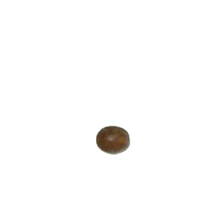

In [9]:
alpha.show()
alpha

In [0]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)

y = to_categorical(y_train)

le = LabelEncoder()
y_v = le.fit_transform(y_test)

y_v = to_categorical(y_v)

In [11]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" 
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

feature_extractor_layer.trainable = False

model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(4)
])

model.summary()
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

print(image.shape)
history = model.fit(x_tr, y, epochs=5, validation_data=(x_v,y_v))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 4)                 5124      
Total params: 2,263,108
Trainable params: 5,124
Non-trainable params: 2,257,984
_________________________________________________________________
(224, 224, 3)
Epoch 1/5
9/9 [==============================] - 14s 2s/step - loss: 0.6483 - acc: 0.8679 - val_loss: 0.1796 - val_acc: 1.0000
Epoch 2/5
9/9 [==============================] - 13s 1s/step - loss: 0.0975 - acc: 1.0000 - val_loss: 0.0412 - val_acc: 1.0000
Epoch 3/5
9/9 [==============================] - 13s 1s/step - loss: 0.0280 - acc: 1.0000 - val_loss: 0.0179 - val_acc: 1.0000
Epoch 4/5
9/9 [==============================] - 13s 1s/step - loss: 0.0143 - acc: 1.0000 - val_loss: 0.0115 

In [12]:
model.evaluate(x_v, y_v)

4/4 [==============================] - 3s 808ms/step - loss: 0.0088 - acc: 1.0000


[0.008760363794863224, 1.0]